In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
import kalman

# パラメータ設定
T = 1000  # データの長さ
a = -0.5  # AR(1)過程のパラメータ
su = 5
sw = 1

# N=1

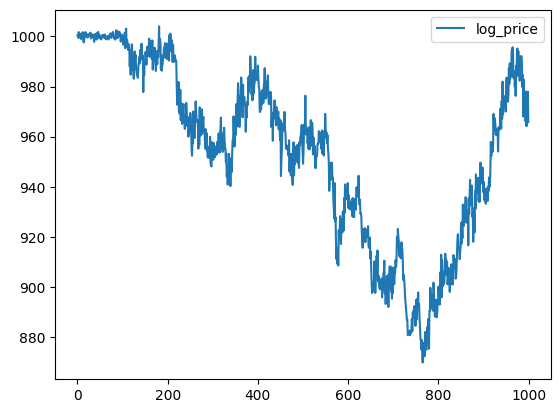

<Axes: >

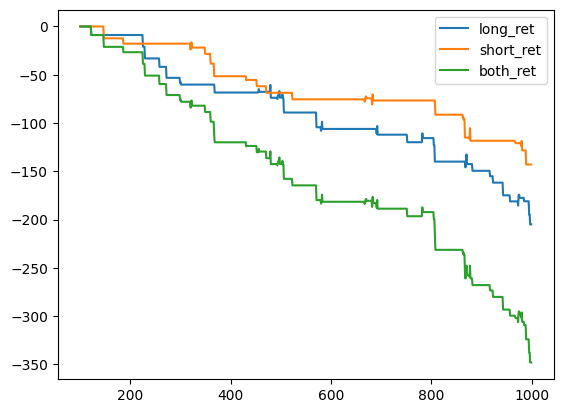

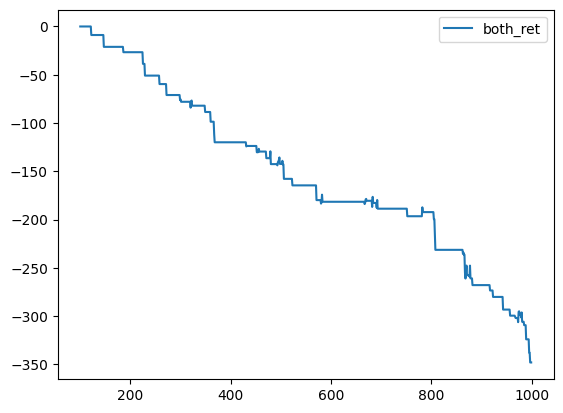

In [19]:
# データ生成
df = kalman.data_gen(a, su, sw, T, True)

# 予測
df = kalman.pred_confidence_interval(df, su, sw)

# トレード損益シミュレーション
df = kalman.calc_return(df)

# 可視化
df[["long_ret","short_ret", "both_ret"]].iloc[100:].cumsum().plot()
df[["both_ret"]].iloc[100:].cumsum().plot()

<Axes: >

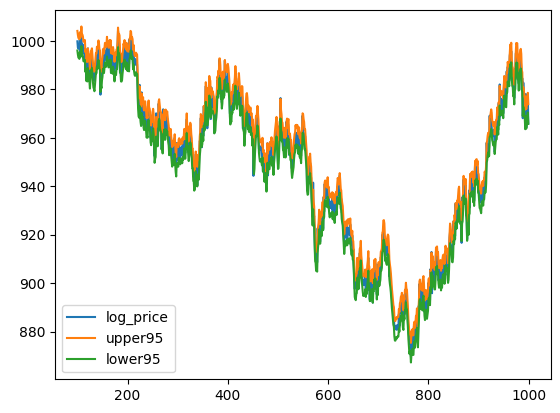

In [20]:
df[["log_price", "upper95", "lower95"]].iloc[100:].plot()

# N=100

[np.float64(-382.3529006967667), np.float64(-357.58996201031243), np.float64(-411.9915907759565), np.float64(-411.95604402437436), np.float64(-337.4816944660588)]
[np.float64(-404.83112079841123), np.float64(-329.4458068486683), np.float64(-416.08624122020217), np.float64(-344.2114497924306), np.float64(-359.7551794822102)]
[np.float64(-327.42475241116426), np.float64(-309.54634457521706), np.float64(-252.42314308076504), np.float64(-365.13683825009787), np.float64(-365.6584316895528)]
[np.float64(-376.6863475925935), np.float64(-462.7620717171935), np.float64(-353.00832795353756), np.float64(-315.76340382286617), np.float64(-263.1765677469232)]
[np.float64(-365.0054176455973), np.float64(-407.7721703098391), np.float64(-441.3228631881947), np.float64(-376.00683366133444), np.float64(-412.5796843998904)]
[np.float64(-378.3694773653052), np.float64(-317.63564889578583), np.float64(-438.62963087946594), np.float64(-304.7140146013004), np.float64(-456.68775728279184)]
[np.float64(-217.764

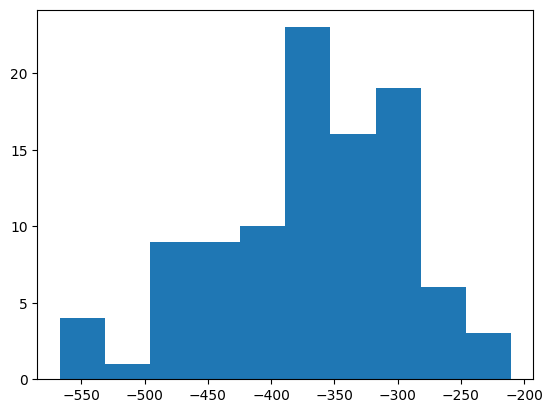

In [21]:
profits = []
for i in range(100):
    # データ生成
    df = kalman.data_gen(a, su, sw, T, False)

    # 予測
    df = kalman.pred_confidence_interval(df, su, sw)

    # トレード損益シミュレーション
    df = kalman.calc_return(df)
    profits.append(df["both_ret"].sum())
    
    batch = 5
    if (i+1)%batch==0:
        print(profits[-batch:])

# 可視化
plt.hist(profits)
plt.show()

In [22]:
(np.array(profits)<0).mean()

np.float64(1.0)

In [23]:
np.min(profits)

np.float64(-567.0523053432669)

In [24]:
np.mean(profits)

np.float64(-370.14256508694484)

In [25]:
np.median(profits)

np.float64(-366.47359636394657)